# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import scipy.stats as ss
from scipy.stats import mannwhitneyu

from tqdm.auto import tqdm

plt.style.use('ggplot')

/Users/nickkulibaba/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('Проект_1_Задание_2.csv', sep=';')

In [4]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [5]:
df.isna().sum() # пропусков нет

user_id      0
revenue      0
testgroup    0
dtype: int64

In [6]:
df.testgroup.unique()

array(['b', 'a'], dtype=object)

In [7]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [8]:
contr = df.query("testgroup == 'a'") # группа а - контрольная

In [9]:
test = df.query("testgroup == 'b'") # группа b - тестовая

### 1. CR - конверсия в покупку

In [10]:
contr.query('revenue > 0').user_id.count() / contr.user_id.count() # контрольная группа

0.009539690157988749

In [11]:
test.query('revenue > 0').user_id.count() / test.user_id.count() # тестовая группа

0.008906235351586593

Конверсия у контрольной группы больше, посмотрим, статистически значимо это или нет. Переменная категориальная, применим хи квадрат

In [12]:
df_CR = df

In [13]:
df_CR['pay'] = np.where(df.revenue > 0, 1, 0)

In [14]:
df_CR = pd.crosstab(df.testgroup, df.pay)
df_CR 

pay,0,1
testgroup,,
a,200175,1928
b,200862,1805


In [15]:
ss.chi2_contingency(df_CR)

Chi2ContingencyResult(statistic=4.374729521260405, pvalue=0.03647561892312613, dof=1, expected_freq=array([[200239.10075104,   1863.89924896],
       [200797.89924896,   1869.10075104]]))

p-value = 0.036, это меньше 0.05, конверсия у контрольной группы больше тестовой и это статистически значимо.

### 2. ARPU - средний доход на пользователя

In [16]:
contr.revenue.mean()

25.413719736965806

In [17]:
test.revenue.mean()

26.75128659327863

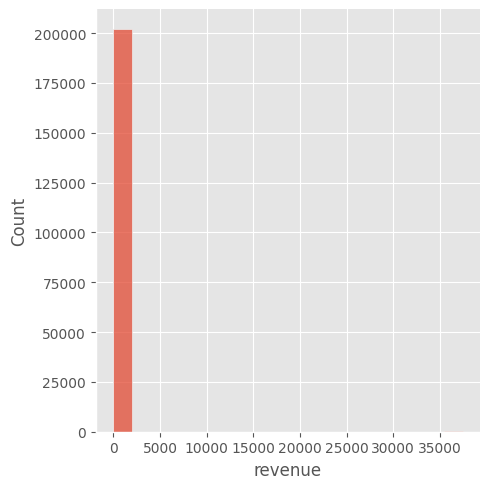

In [18]:
sns.displot(contr.revenue) # распределение группа а

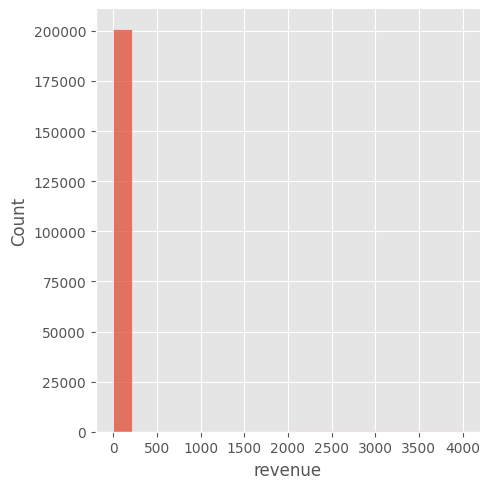

In [19]:
sns.displot(test.revenue) # распределение группа b

<Axes: xlabel='testgroup', ylabel='revenue'>

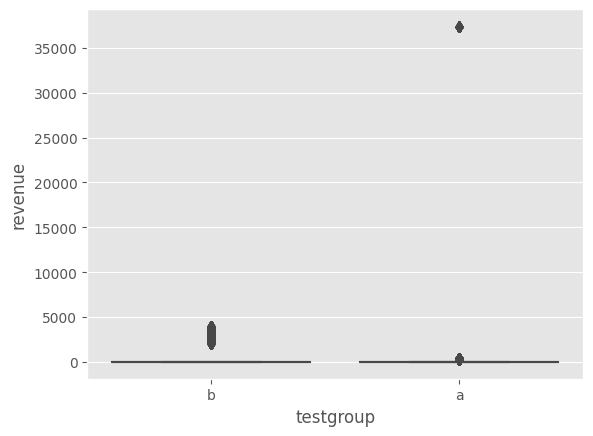

In [20]:
sns.boxplot(x='testgroup', y='revenue', data=df) # выбросы 

по распределениям видны выбросы в группе а, посмотрим, помешают они нам в тестах или нет.

In [21]:
print('Доля выбросов от всего числа наблюдений группы а составляет', round((contr.query('revenue > 5000').revenue.count() / contr.revenue.count())*100, 2), '%')

Доля выбросов от всего числа наблюдений группы а составляет 0.06 %


In [22]:
print('Доля заработанных денег от выбросов группы а составляет', round(contr.query('revenue > 5000').revenue.sum() / contr.revenue.sum() *100, 2), '%')

Доля заработанных денег от выбросов группы а составляет 89.37 %


Выбросы оставляем и будем их учитывать в тестах, потому что:

% выбросов маленький (0,06)  
% заработанных денег ощутимый (89,37)

In [23]:
ss.levene(contr.revenue, test.revenue, center='mean') # тест Левена на гомогенность дисперсий

LeveneResult(statistic=1.57736044973474, pvalue=0.2091420343022563)

In [24]:
ss.levene(contr.revenue, test.revenue, center='median') # тест Левена на гомогенность дисперсий

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

pvalue > 0.05, дисперсии гомогенны

In [25]:
print('контрольная группа ', ss.shapiro(contr.revenue.sample(n=1000))) # тест Шапиро-Уилка на нормальность
print('тестовая группа', ss.shapiro(test.revenue.sample(n=1000)))

контрольная группа  ShapiroResult(statistic=0.022326767444610596, pvalue=0.0)
тестовая группа ShapiroResult(statistic=0.07766050100326538, pvalue=0.0)


pvalue < 0.05, распределения не нормальны

In [26]:
print('контрольная группа', ss.normaltest(contr.revenue)) # Тест Д’Агостино и Пирсона на нормальность
print('тестовая группа', ss.normaltest(test.revenue))

контрольная группа NormaltestResult(statistic=585152.7312728433, pvalue=0.0)
тестовая группа NormaltestResult(statistic=326622.39540856465, pvalue=0.0)


pvalue < 0.05, распределения не нормальны

Распределения не нормальны, но у нас большая выборка (для нормальности т-теста надо менее 30) и количество наблюдений почти одинаковое, поэтому можем применить t-тест Стьюдента.

In [27]:
ttest_ind(contr.revenue, test.revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

При проведении t-теста нулевая гипотеза состоит в том, что различий между значениями средних нет. Значение pvalue больше 0.05, принимаем Н0, различия статистически между ARPU не значительны.

### 3. ARPPU - средний доход на платящего пользователя

In [28]:
contr.query('revenue > 0').revenue.mean()

2663.9984439834025

In [29]:
test.query('revenue > 0').revenue.mean()

3003.6581717451522

ARPPU тестовой группы больше контрольной, посмотрим, статистически значимо ли это.

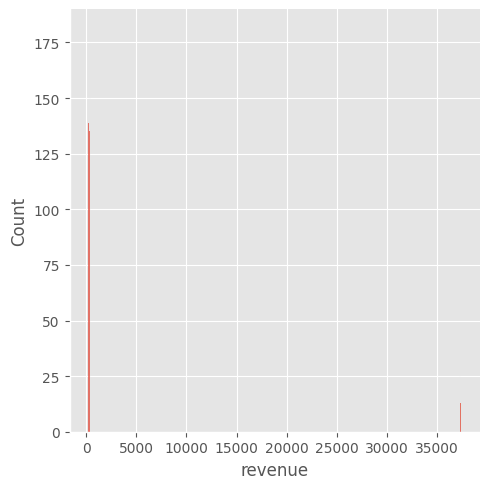

In [30]:
sns.displot(contr.query('revenue > 0').revenue) # распределение группа а платящие

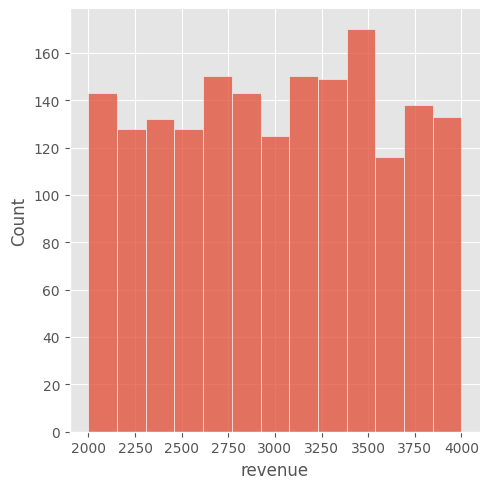

In [31]:
sns.displot(test.query('revenue > 0').revenue) # распределение группа b платящие

<Axes: xlabel='testgroup', ylabel='revenue'>

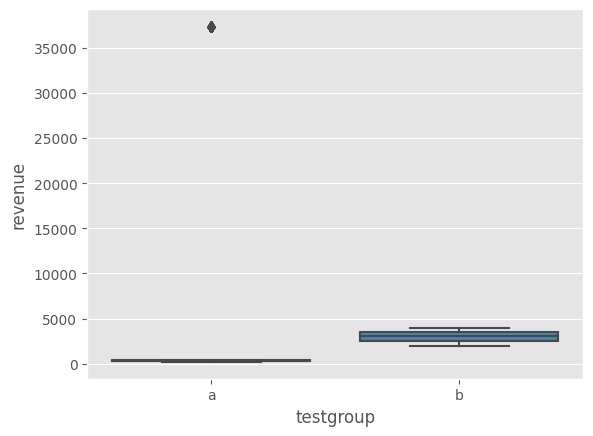

In [32]:
sns.boxplot(x='testgroup', y='revenue', data=df.query('revenue > 0')) # выбросы у платящих

In [33]:
print('Доля выбросов от всего числа наблюдений группы а составляет', round((contr.query('revenue > 5000').revenue.count() / contr.query('revenue > 0').revenue.count())*100, 2), '%')

Доля выбросов от всего числа наблюдений группы а составляет 6.38 %


In [34]:
print('Доля заработанных денег от выбросов группы а составляет', round(contr.query('revenue > 5000').revenue.sum() / contr.query('revenue > 0').revenue.sum() *100, 2), '%')

Доля заработанных денег от выбросов группы а составляет 89.37 %


Выбросы оставляем и будем их учитывать в тестах, потому что:

% выбросов увеличился, по сравнению с общим количеством (6,38), но для бизнеса важен  
% заработанных денег, который составляет 89,37 %

In [35]:
ss.levene(contr.query('revenue > 0').revenue, test.query('revenue > 0').revenue, center='mean') # тест Левена на гомогенность дисперсий

LeveneResult(statistic=445.9869447066088, pvalue=1.3202514573715939e-93)

In [36]:
ss.levene(contr.query('revenue > 0').revenue, test.query('revenue > 0').revenue, center='median') # тест Левена на гомогенность дисперсий

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

pvalue < 0.05, дисперсии не гомогенны

In [37]:
print('контрольная группа ', ss.shapiro(contr.query('revenue > 0').revenue.sample(n=1000))) # тест Шапиро-Уилка на нормальность
print('тестовая группа', ss.shapiro(test.query('revenue > 0').revenue.sample(n=1000)))

контрольная группа  ShapiroResult(statistic=0.26972025632858276, pvalue=0.0)
тестовая группа ShapiroResult(statistic=0.9546468257904053, pvalue=5.000910975602461e-17)


In [38]:
print('контрольная группа', ss.normaltest(contr.query('revenue > 0').revenue)) # Тест Д’Агостино и Пирсона на нормальность
print('тестовая группа', ss.normaltest(test.query('revenue > 0').revenue))

контрольная группа NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)
тестовая группа NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)


pvalue < 0.05, распределения не нормальны

Получается, что дисперсии не гомогенны и распределения не нормальны, поэтому будем использовать бутстрап, причем будем сравнивать не средние mean, а медианные median, потому что процент выбросов у нас аж 6.38, что много и для средних будет искажение результата, а для медианных - норм.

In [39]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5408.86it/s]


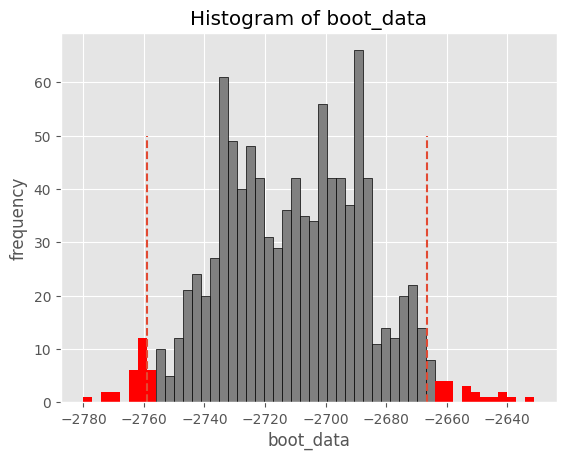

In [40]:
arppu_bootstrap_median = get_bootstrap(contr.query('revenue > 0').revenue, test.query('revenue > 0').revenue, statistic = np.median) 

In [41]:
arppu_bootstrap_median["p_value"]

0.0

При применении бутстрапа  с методом statistic = np.median pvalue < 0.05, отклоняем нулевую гипотезу, различия ARPPU между группами статистически значимые.

### 4. Total money

In [42]:
contr.revenue.sum()

5136189

In [43]:
test.revenue.sum()

5421603

In [44]:
diff = test.revenue.sum() - contr.revenue.sum()
print ('общий доход в тестовой группе больше на', diff, ', и это составляет',round(diff / test.revenue.sum() * 100,2),'%')

общий доход в тестовой группе больше на 285414 , и это составляет 5.26 %


### ИТОГО:
    1. конверсия CR у контрольной группы больше и это статистически значимо
    2. различия между средним доходом на пользователя ARPU статистически не значительны
    3. средний доход на платящего пользователя ARPPU у тестовой группы больше и это статистически значимо.
    4. общий доход в тестовой группе больше
    
Пользователи из тестовой группы меньше платят, но при этом на платящего пользователя у них доход больше, доходы равномерные и легче прогнозируемые (в отличие от контрольной группы, где много маленьких доходов и очень низкий процент больших). Также общий доход в тестовой группе больше. Если пользователи будут уходить, то для контрольной группы это будет более критично, чем для тестовой. Получается, что предложение тестовой группы можно считать лучшим.